In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
import numpy as np
from src.layers.attention import HeadAttentionMulti, scaled_dot_product_attention
from src.models.astromer_1 import get_ASTROMER
from src.data import load_data
from src.metrics.r2 import custom_r2
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

2023-10-11 17:39:47.330900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
data = load_data('./data/records/atlas/fold_0/atlas_50/test/',
                    batch_size=50,
                    window_size=10,
                    probed=0.5,
                    random_same=.2,
                    sampling=True,
                    nsp_prob=.5)

[INFO] Sampling random windows


In [8]:
for x, y in data.take(1):
    
    print(x['magnitudes'].shape)

(50, 10, 1)


In [9]:
from src.models.astromer_2 import get_ASTROMER

In [27]:
model = get_ASTROMER(num_layers=2,
                     num_heads=2,
                     head_dim=64,
                     mixer_size=256,
                     dropout=0.1,
                     pe_base=1000,
                     pe_dim=128,
                     pe_c=1,
                     window_size=10,
                     encoder_mode='nsp',
                     average_layers=False)

In [28]:
model.summary()

Model: "ASTROMER_NSP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 att_mask (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 magnitudes (InputLayer)        [(None, 10, 1)]      0           []                               
                                                                                                  
 seg_emb (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 times (InputLayer)             [(None, 10, 1)]      0           []                               
                                                                                       

In [33]:
for x, y in data.take(1):
    pred = model(x)
    
    print(y['probed_mask'].shape)
    print(pred['reconstruction'].shape)

(50, 10, 1)
(50, 10, 1)


In [56]:
for x, y in data.take(1):

    q = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    k = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    v = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    
    output, weights, mask = scaled_dot_product_attention(q, k, v, 
                                                         mask=x['att_mask'], 
                                                         return_mask=True)

In [57]:
mask.shape, weights.shape

(TensorShape([50, 1, 10, 10]), TensorShape([50, 4, 10, 10]))

tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)


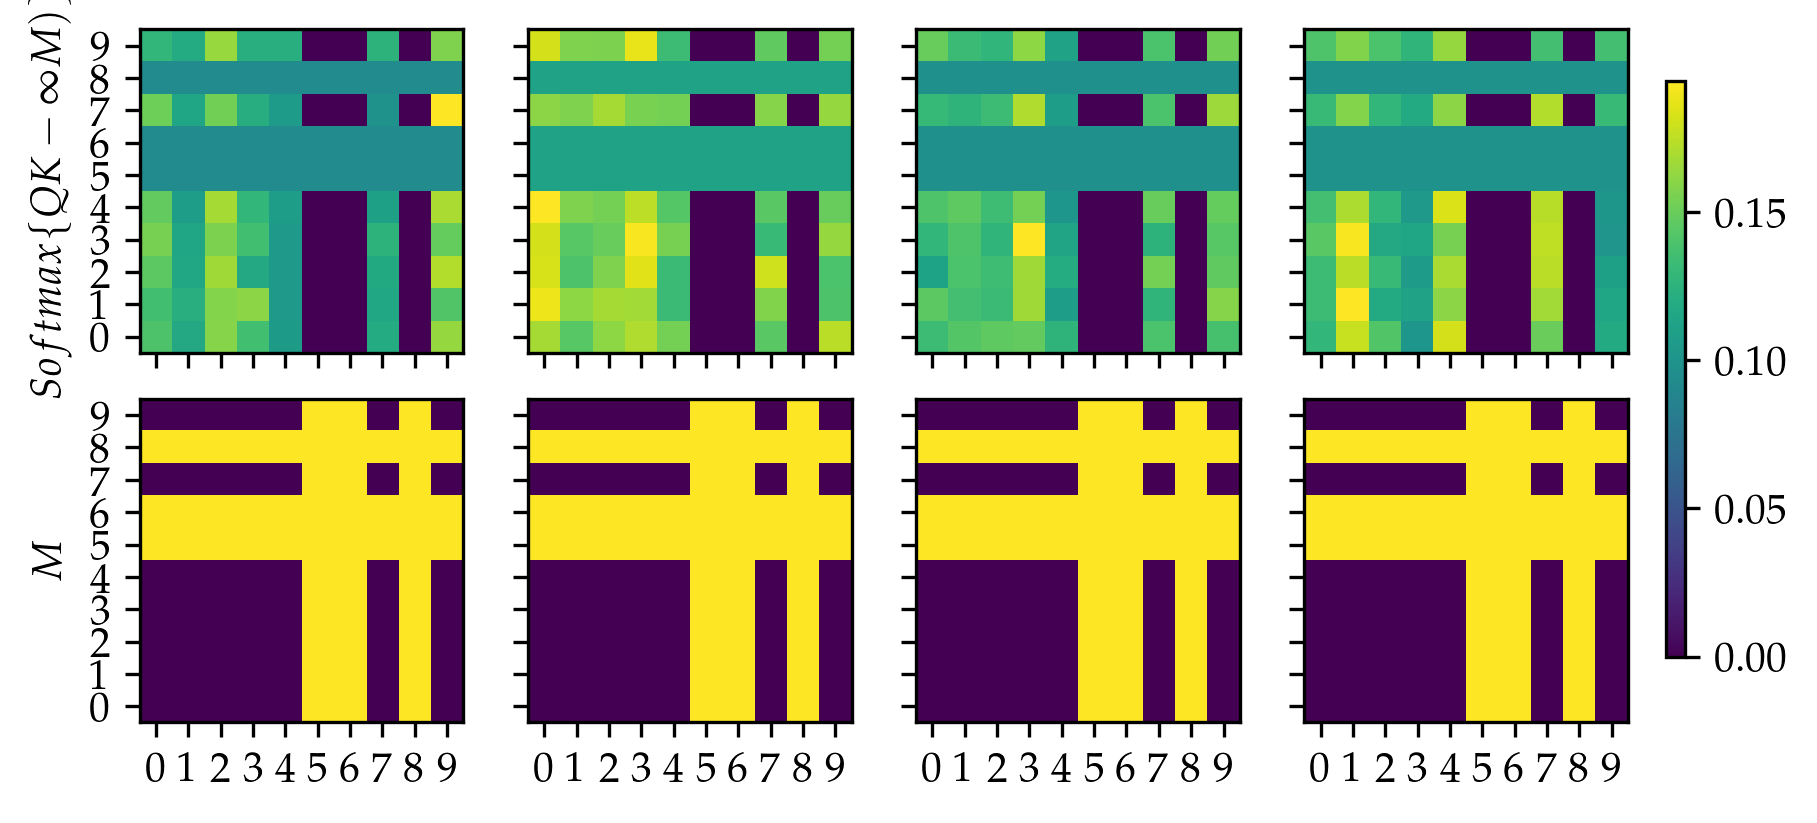

In [93]:
fig, axes = plt.subplots(2, 4, dpi=300, 
                         gridspec_kw={'hspace': -0.5, 'wspace': 0.2}, 
                         sharex=True, sharey=True)
for i in range(4):
    print(x['att_mask'][0, :, 0])
    prod = weights*(1.-mask)
    im = axes[0][i].imshow(weights[0, i], extent=(0, 10, 0, 10))
    axes[0][i].set_xticks(range(10))
    axes[0][i].set_yticks(range(10))


    axes[1][i].imshow(mask[0, 0], extent=(0, 10, 0, 10))
    
    for k in range(2):
        axes[k][i].set_xticks(np.arange(0.5, 10.5))
        axes[k][i].set_yticks(np.arange(0.5, 10.5))
        axes[k][i].set_xticklabels(np.arange(0, 10))
        axes[k][i].set_yticklabels(np.arange(0, 10))
    
    axes[0][0].set_ylabel(r'$Softmax{\{QK-\infty M)\}}$')
    axes[1][0].set_ylabel(r'$M$')
    
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
fig.colorbar(im, cax=cbar_ax)

In [11]:
model = get_ASTROMER(window_size=10)
for x, y in data.take(1):
    y_pred = model(x)
    

In [12]:
custom_r2(y['magnitudes'], y_pred, y['probed_mask'])

<tf.Tensor: shape=(), dtype=float32, numpy=-52.31381>